<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Xander Gallegos, Carlos Emiliano Rodríguez.

**Fecha:** 15 de febrero del 2024.

**Expediente** : 737989, XXXXXX.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: <a href=https://github.com/xagallegos/ProyectoConjunto_XGallegos_CERodriguez>ProyectoConjunto_XGallegos_CERodriguez</a>

# Tarea 3: Clase 7

## Enunciado de tarea 

> Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado.

> Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase. Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos: <https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true>

### Ejercicio 1: Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado.

Código de solución estudiante 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from io import BytesIO
from sklearn.preprocessing import power_transform, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Código de solución estudiante 1
class LinearForecast:
    def __init__(self, file_path, file_type='csv', kwargs = dict(), train_split=0.8):
        if file_type == 'csv':
            self.data = pd.read_csv(file_path, **kwargs)
        elif file_type == 'xlsx':
            self.data = pd.read_excel(file_path, **kwargs)
        else:
            raise ValueError(f'Unexpected value "{file_type}"')

    def seasonal_decomposition(self, periods_seasonality, plot=False):
        decomposition_model = MSTL(self.data.copy(), periods=periods_seasonality, stl_kwargs={"seasonal_deg": 0} )
        result = decomposition_model.fit()
        self.periods = periods_seasonality
        self.decomposed_series = result
        
        if plot is True:
            n = 3 + len(periods_seasonality)
            fig, axes = plt.subplots(n, 1, figsize=(8,8))
            
            result.observed.plot(ax=axes[0])
            axes[0].set_ylabel('Observed')

            result.trend.plot(ax=axes[1])
            axes[1].set_ylabel('Trend')

            for i, period in enumerate(periods_seasonality):
                result.seasonal[f'seasonal_{period}'].plot(ax=axes[2+i])
                axes[2+i].set_ylabel(f'seasonal_{period}')

            result.resid.plot(ax=axes[-1])
            axes[-1].set_ylabel('Residual')

            fig, ax = plt.subplots(figsize=(8,4))
            result.observed.plot(label='observados', ax=ax)

            for period in periods_seasonality:
                result.seasonal[f'seasonal_{period}'].plot(ax = ax, label=f'seasonal_{period}')
            
            plt.legend()
            plt.show()
        
    def  plot_non_seasonal(self):
        self.non_seasonal = self.decomposed_series.observed
        for period in self.periods:
            self.non_seasonal -= self.decomposed_series.seasonal[f'seasonal_{period}']

        fig = plt.figure(figsize=(8,4))
        self.non_seasonal.plot(label='non_seasonal')
        self.decomposed_series.observed.plot(label='observed')
        plt.legend()
        plt.show()

    
    def adf_test(self, seasonal_period=False, diff=0):
        if seasonal_period is False:
            data = self.data
        elif seasonal_period == 'non_seasonal':
            data = self.non_seasonal
        else:
            data = self.decomposed_series.seasonal[seasonal_period]
        
        for i in range(diff):
            data = data.diff().dropna()
            
        dftest = adfuller(data, autolag = "AIC")
        dfoutput = pd.Series(dftest[0:4],
                             index = ["Test Statistic",
                                      "p-value",
                                      "#Lags Used",
                                      "Number of Observations Used"])
        
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
            
        print(f"Results of Dickey-Fuller Test: (diff: {diff})")
        print(dfoutput)
        
        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")
            
    def plot_acf_pac(self, diff=0, seasonal_period=False, kwargs=dict()):        
        if seasonal_period is False:
            data = self.data
        elif seasonal_period == 'non_seasonal':
            data = self.non_seasonal
        else:
            data = self.decomposed_series.seasonal[seasonal_period]
        
        for i in range(diff):
            data = data.diff().dropna()
        
        f = plt.figure(figsize=(10,3))

        ax1 = f.add_subplot(121)
        plot_acf(data, zero=False, ax=ax1, **kwargs)
    
        ax2 = f.add_subplot(122)
        plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)
    
        plt.show()

    def transform_timeseries(self, how='sqrt'):
        if how == 'sqrt':
            return np.sqrt(self.data)
        elif how == 'log':
            return np.log(self.data)
        elif how in ['box-cox', 'yeo-johnson']:
            return power_transform(self.data.to_numpy().reshape(-1,1), method=how)
        elif how == 'min-max-scaler':
            scaler = MinMaxScaler()
            return scaler.fit_transform(self.data)
        elif how == 'std-scaler':
            scaler = StandardScaler()
            return scaler.fit_transform(self.data.values.reshape(-1, 1))
        else:
            raise ValueError(f'Unexpected value "{how}"')

    def sarimax_model(self, params):
        non_seasonal, seasonal, trend = params
        model = SARIMAX(
            endog = self.data,
            trend = trend,
            order = non_seasonal,
            seasonal_order = seasonal
        )
        self.model = model.fit()

    def predict(self, start, end, model='last', plot=False):
        if model == 'last':
            model = self.model
            
        y_h = model.predict(start=start, end=end)

        if plot is True:
            fig = plt.figure()
            self.data.iloc[self.data.index >= start].plot(label='data')
            y_h.plot(label='pred')
            plt.legend()
            plt.show()
            
        return y_h
    
    def eval_model(self):
        y_h = self.model.predict()

        mape = mean_absolute_percentage_error(y_true = self.data, y_pred=y_h)
        mad = np.mean(np.abs(np.subtract(self.data, y_h)))
        return mape, mad
        

Código de solución estudiante 2

In [17]:
# Código de solución estudiante 2

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import MSTL
import itertools
from sklearn.preprocessing import power_transform
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

import warnings
warnings.filterwarnings("ignore")

class timeseries:
    
    def __init__(self, data):
        self.data = data

    def set_time_seties(self, target, dateColumn = 'date'):
        timeseries = self.data[[dateColumn, target]]
        timeseries.columns = ['date', 'y']
        timeseries['date'] = pd.to_datetime(timeseries['date'])
        timeseries = timeseries.set_index('date').resample('M').mean()
        self.timeseries = timeseries
        self.use_param = timeseries
        return self.timeseries.tail()

    def set_time_series_slice(self, fraction = 1000):
        self.slice = fraction
        self.fraction = self.timeseries[:fraction]
        self.use_param = self.fraction

    def plot_ts(self):
        return self.use_param.plot()

    def adf_test(self, self_param = True, extra = ''):
        print("Results of Dickey-Fuller Test:")
        if self_param:
            series = self.timeseries
        else:
            series = extra
        dftest = adfuller(series, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=["Test Statistic", "p-value",
                "#Lags Used", "Number of Observations Used",],)
        
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)
        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

    def plot_acf_pacf(self, withDiff = 0, kwargs={'lags' : 40}, self_param = True, extra = ''):

        f = plt.figure(figsize=(10,8))
        if self_param:
            series = self.use_param
        else:
            series = extra
        for _ in range(withDiff):
            series = series.diff().dropna()
            
        ax1 = f.add_subplot(121)
        plot_acf(series, zero=False, ax=ax1, **kwargs)
        ax2 = f.add_subplot(122)
        plot_pacf(series, zero=False, ax=ax2, method='ols', **kwargs)
        plt.show()

    def season_decomp(self, seasons):

        self.seasons = seasons
        data1 = self.timeseries.copy()
        periods_seasons = self.seasons
        stl_kwargs = {"seasonal_deg": 0} 
        modelo = MSTL(data1, periods=periods_seasons, stl_kwargs=stl_kwargs)
        res2 = modelo.fit()
        self.res2 = res2
        
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))
        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')
        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')
        res2.seasonal[f'seasonal_{periods_seasons[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasons[0]}')
        res2.seasonal[f'seasonal_{periods_seasons[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasons[1]}')
        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')
        fig.tight_layout()
        ax = res2.observed.to_frame('observados')[:self.slice].plot()
        res2.seasonal[:self.slice].plot(ax = ax)

    def stationarity(self):
        j = {}
        for i in self.seasons:
            h = f'seasonal_{i}'
            print(h)
            j[h] = self.res2.seasonal[h]
            self.adf_test(self_param = False, extra = j[h])
            print('Sin diferenciar')
            self.plot_acf_pacf(self_param = False, extra = j[h])
            print('Diferenciada')
            self.plot_acf_pacf(withDiff=1, self_param = False, extra = j[h])
            print('\n')
        self.j = j

    def non_stat_comp(self, seasons):
        self.adf_test(self_param=False, extra=self.res2.observed)
        non_seasonal = self.res2.observed - self.res2.seasonal[f'seasonal_{seasons}']
        non_seasonal.plot()
        
        self.adf_test(self_param=False, extra = non_seasonal)
        print('Sin diferenciar')
        self.plot_acf_pacf(self_param = False, extra = non_seasonal)
        print('Diferenciada')
        self.plot_acf_pacf(withDiff=1, self_param = False, extra = non_seasonal)
        print('Diferenciada 2 veces')
        self.plot_acf_pacf(withDiff=2, self_param = False, extra = non_seasonal)
        self.non_seasonal = non_seasonal
        self.chosenseasons = seasons

    def sarimax_param(self, p, d, q, P, D, Q, t=['n', 'c', 't', 'ct']):
        params_no_estacionales = list(itertools.product(p, d, q))
        params_estacionales = [(x[0], x[1], x[2], self.chosenseasons) for x in list(itertools.product(P, D, Q))]
        sarimax_params = list(itertools.product(params_no_estacionales, params_estacionales, t))
        self.sarimax_params = sarimax_params

    def scale_data(self):
        vals = power_transform(self.timeseries['y'].to_numpy().reshape(-1, 1), method='yeo-johnson')
        self.scaledData = vals
    
    def find_param(self):
        self.scale_data()
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index = np.arange(0, 11))
        # print(f'Trying out {len(self.sarimax_params)} posible combinations')
        i = 0
        for par_no_season, par_season, trend in self.sarimax_params:

            mod = SARIMAX(endog= self.scaledData, trend= trend,
                order= par_no_season, seasonal_order= par_season)
            results = mod.fit()
            
            # print(f'Model done for params: {par_no_season}, {par_season}, {trend}')
            resultados.loc[i, 'params'] = str((par_no_season, par_season, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1
        self.resultadosParams = resultados
        return self.resultadosParams

    def sarimax_model(self, no_season, season, trend):
        modelo = SARIMAX(
                endog= self.scaledData, trend= trend,
                order= no_season, seasonal_order= season,
                enforce_stationarity=False, enforce_invertibility=False)
        
        results = modelo.fit()
        self.sarimax = results
        return results.summary()

    def prediction(self, size):
        end = len(self.timeseries)
        start = end-size
        actual = self.scaledData[start:end]
        predicted = self.sarimax.predict(start = start+1, end = end, dynamic = True)
        actual = actual.reshape(size,)
        assert actual.shape == predicted.shape
        self.actual = actual
        self.predicted = predicted
        predictions = pd.DataFrame({'actual': actual, 'predicted': predicted}, index=self.timeseries.index[start:end])
        fig, ax = plt.subplots(figsize=(12,8))
        predictions.actual.plot(ax = ax)
        predictions.predicted.plot(ax =ax)
        ax.legend(labels = ['actual', 'forecast'])

    def calculate_mape(self) -> float:
        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)
        self.mape =  round(np.mean(np.abs((self.actual - self.predicted) / self.actual)) * 100, 2)

    def calculate_mad(self) -> float:
        if not all([isinstance(self.actual, np.ndarray), isinstance(self.predicted, np.ndarray)]):
            self.actual, self.predicted = np.array(self.actual), np.array(self.predicted)
        self.mad =  round(np.mean(np.abs(self.actual - self.predicted)) * 100, 2)

### Ejercicio 2: Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase. Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos: <https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true>

Código de solución de estudiante 1

In [3]:
# Código de solución de estudiante 1
file = 'https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true'
forecast = LinearForecast(file, 'xlsx')

In [4]:
def prepare_df(df):
    # Sumar fecha y hora
    df.date = [d + pd.Timedelta(h, unit='hour') for d, h in df[['date', 'hour']].values]
    df.set_index('date', inplace=True) # asignarla como índice
    
    # Conservar únicamente la fecha y la columna a predecir -> energía
    df.drop(columns = [c for c in df.columns if c != 'Energy (kWh)'], inplace=True)

    # Resample por promedio del mes
    df = df.resample('m').mean()
    return df

In [5]:
forecast.data = prepare_df(forecast.data)

print(forecast.data.shape)
forecast.data.head()

(300, 1)


,Energy (kWh)
date,
1990-01-31,451.887005
1990-02-28,423.897505
1990-03-31,430.298776
1990-04-30,296.197605
1990-05-31,288.352006


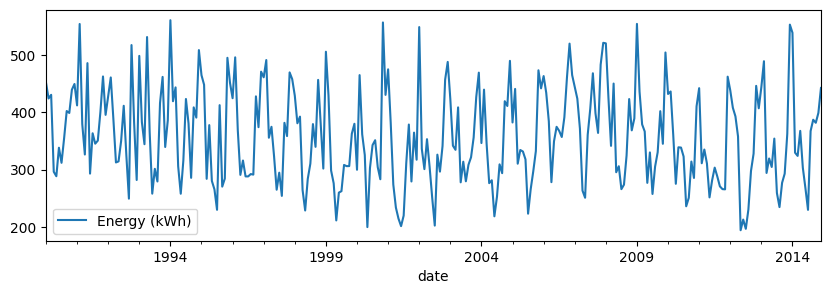

In [6]:
# Graficar la serie de tiempo
forecast.data.plot(figsize=(10,3))
plt.show()

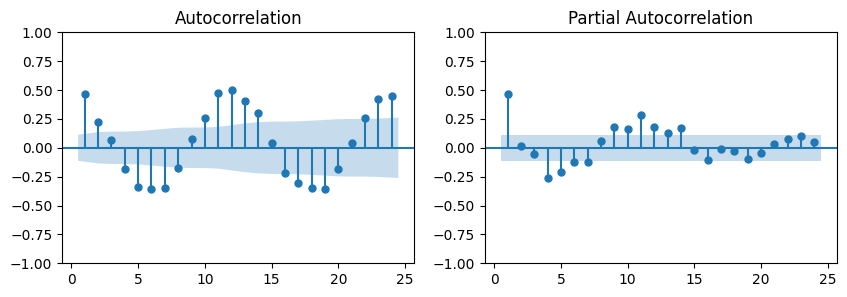

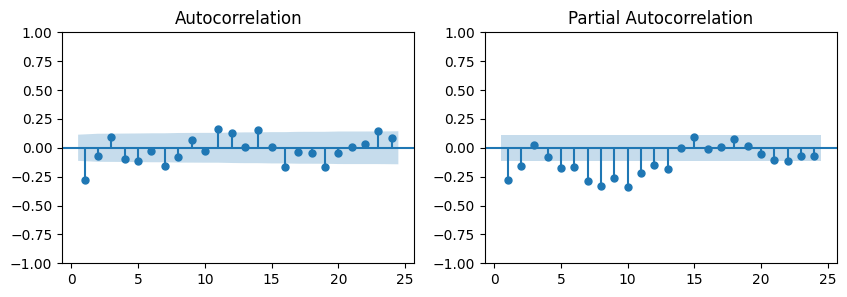

In [7]:
# Graficar ACF y PAC
forecast.plot_acf_pac(kwargs={'lags': 24})
forecast.plot_acf_pac(diff=1, kwargs={'lags': 24})
# forecast.plot_acf_pac(diff=2, kwargs={'lags': 24})

In [8]:
forecast.adf_test()
forecast.adf_test(diff=1)
# forecast.adf_test(diff=2)

Results of Dickey-Fuller Test: (diff: 0)
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary
Results of Dickey-Fuller Test: (diff: 1)
Test Statistic                -1.185352e+01
p-value                        7.115964e-22
#Lags Used                     1.200000e+01
Number of Observations Used    2.860000e+02
Critical Value (1%)           -3.453423e+00
Critical Value (5%)           -2.871699e+00
Critical Value (10%)          -2.572183e+00
dtype: float64
Stationary


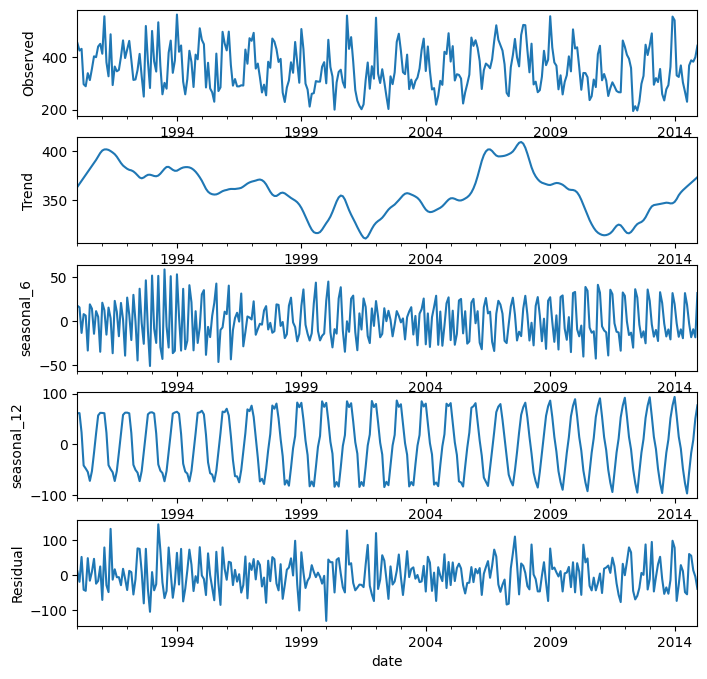

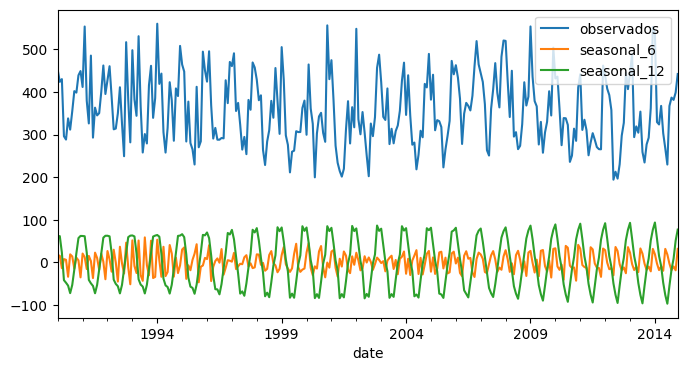

In [9]:
forecast.seasonal_decomposition((6,12), plot=True)

**Componente estacional**

In [10]:
forecast.adf_test(seasonal_period = 'seasonal_12')
# forecast.adf_test(diff=1, seasonal_period = 'seasonal_12')
# forecast.adf_test(diff=2, seasonal_period = 'seasonal_12')

Results of Dickey-Fuller Test: (diff: 0)
Test Statistic                 -29.256349
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary


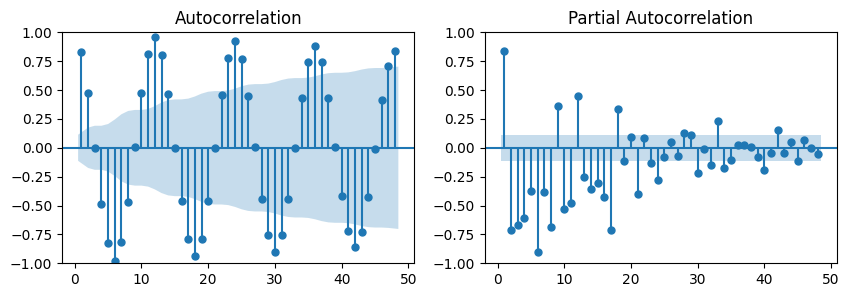

In [11]:
forecast.plot_acf_pac(seasonal_period='seasonal_12', kwargs={'lags':48})
# forecast.plot_acf_pac(diff=1, seasonal_period='seasonal_12', kwargs={'lags':48})
# forecast.plot_acf_pac(diff=2, seasonal_period='seasonal_12', kwargs={'lags':48})

$(P, D, Q) = (2, 0, 2)$

**Componente no estacional**

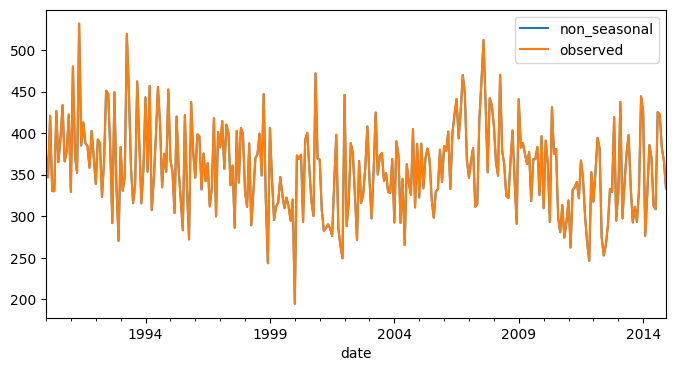

In [12]:
forecast.plot_non_seasonal()

In [13]:
forecast.adf_test(seasonal_period='non_seasonal')
forecast.adf_test(diff=1, seasonal_period='non_seasonal')

Results of Dickey-Fuller Test: (diff: 0)
Test Statistic                  -2.652388
p-value                          0.082646
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary
Results of Dickey-Fuller Test: (diff: 1)
Test Statistic                -7.982167e+00
p-value                        2.605812e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64
Stationary


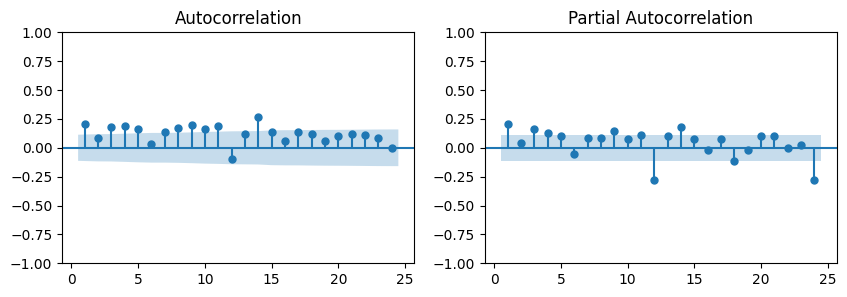

In [14]:
forecast.plot_acf_pac(seasonal_period='non_seasonal', kwargs={'lags':24})

$(p, d, q) = (0, 1, 0)$

**Model and predictions**

<Figure size 640x480 with 0 Axes>

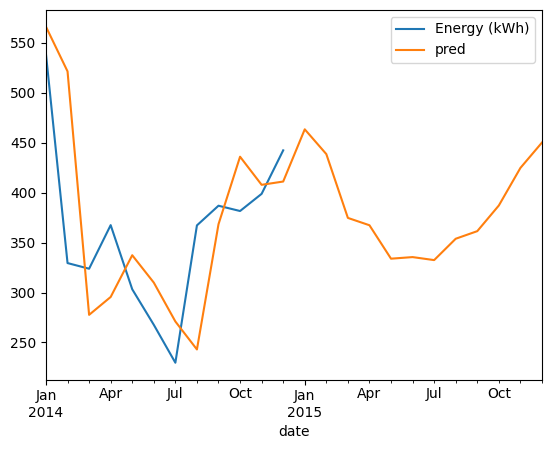

In [15]:
forecast.sarimax_model(((0,1,0), (2,0,2,12), 'n'))
y_h = forecast.predict(start='2014-01-31', end='2015-12-31', plot=True)

In [16]:
mape, mad = forecast.eval_model()

print(f'>> mape: {mape}')
print(f'>> mad:  {mad}')

>> mape: 0.17957397655676177
>> mad:  nan


Código de solución de estudiante 2

In [18]:
# Código de solución de estudiante 2
url = 'https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true'
data = pd.read_excel(url)

df = data.copy()
df['date'] = df.apply(lambda x: x['date'] + pd.Timedelta(x['hour'], 'h'), axis = 1)
df.head()

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01 06:00:00,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01 07:00:00,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01 08:00:00,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01 09:00:00,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01 10:00:00,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230


Plot Time Series


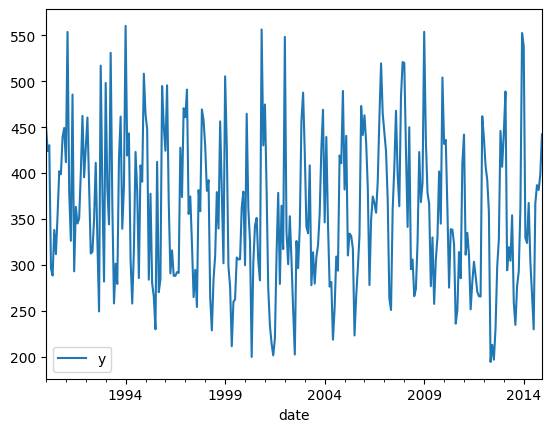

In [19]:
modelo = timeseries(df)
modelo.set_time_seties('Energy (kWh)')

print("Plot Time Series")
modelo.plot_ts();

Set Time Series Slice y Plot Acf Pacf


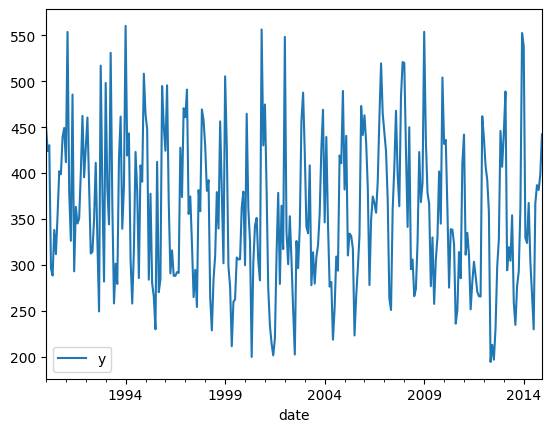

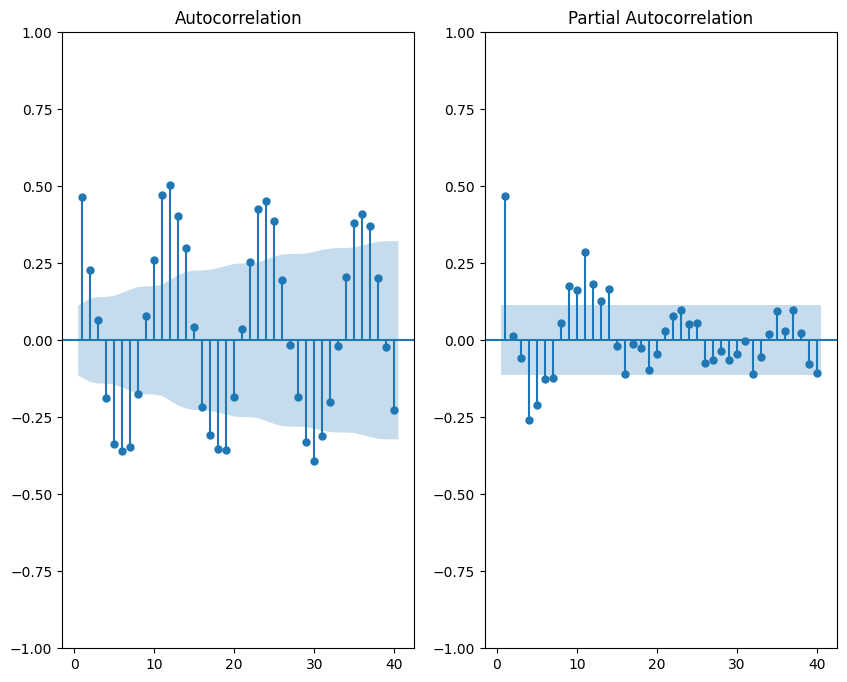

In [20]:
print("Set Time Series Slice y Plot Acf Pacf")
modelo.set_time_series_slice()
modelo.plot_ts()

modelo.plot_acf_pacf(kwargs={'lags': 40})

Plot Acf Pacf 1


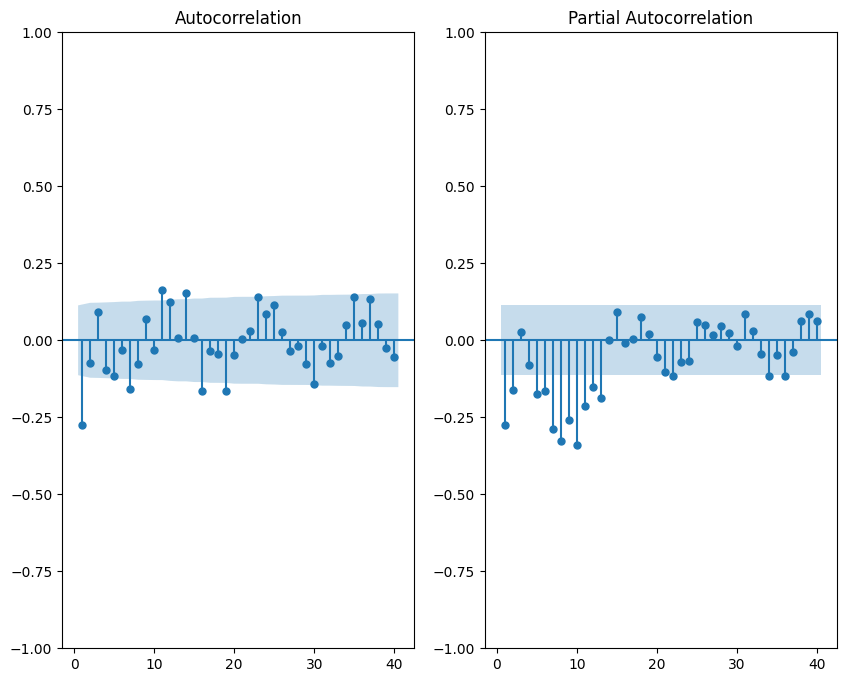

Seasonal Decompose


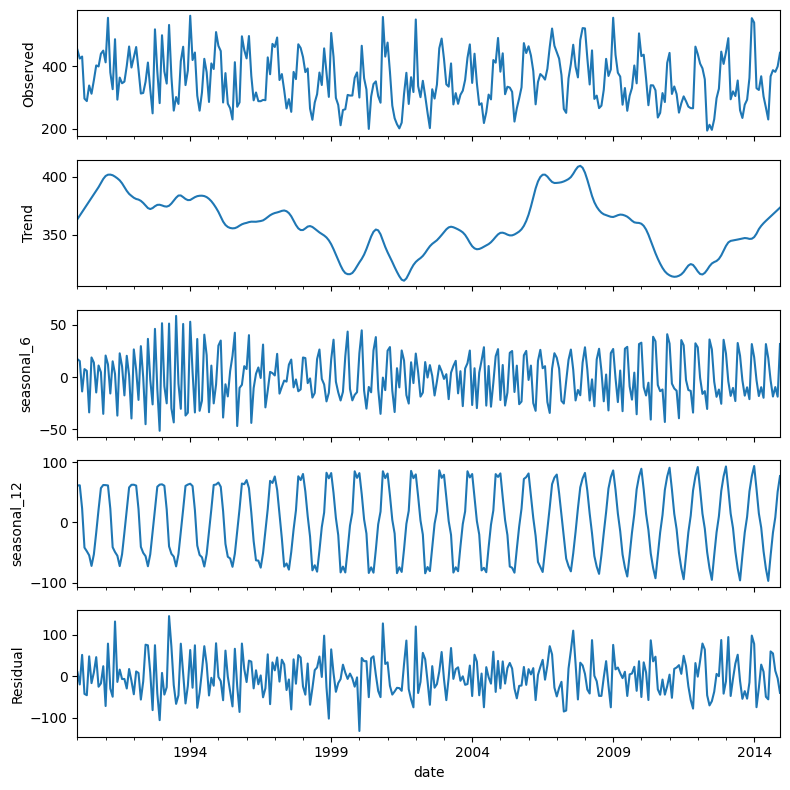

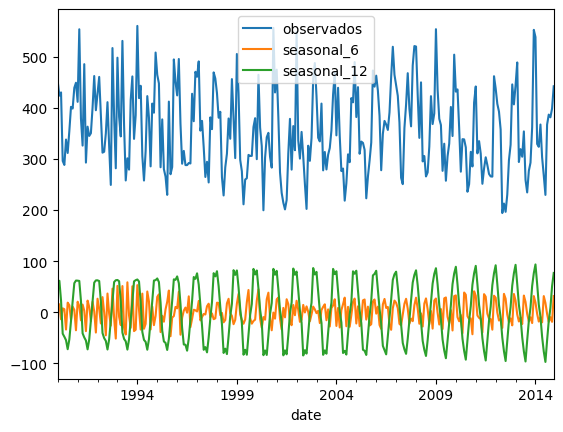

In [21]:
print("Plot Acf Pacf 1")
modelo.plot_acf_pacf(1, kwargs={'lags': 40})

print("Seasonal Decompose")
modelo.season_decomp((6, 12))

seasonal_6
Results of Dickey-Fuller Test:
Test Statistic                -9.451841e+00
p-value                        4.594080e-16
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary
Sin diferenciar


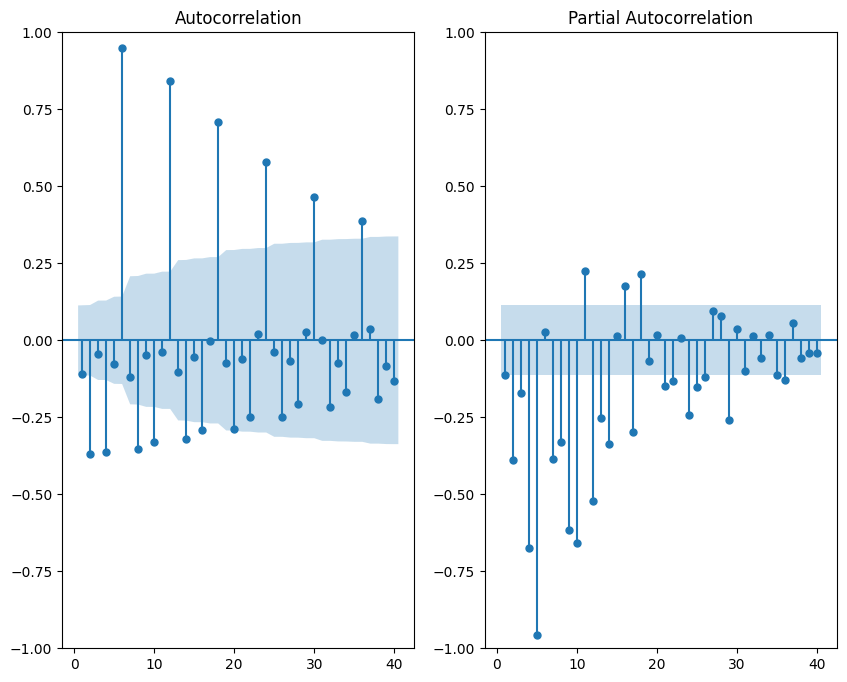

Diferenciada


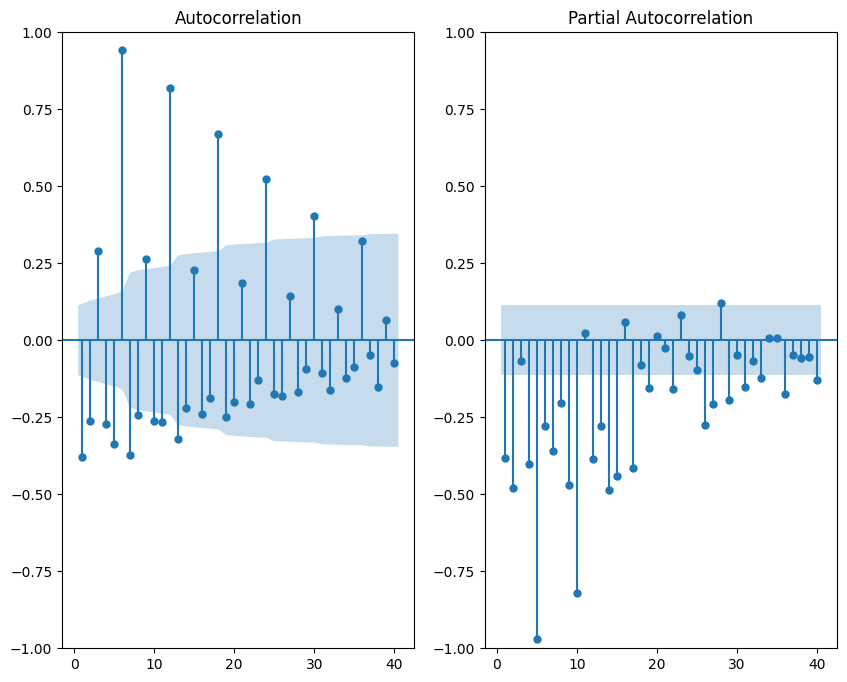



seasonal_12
Results of Dickey-Fuller Test:
Test Statistic                 -29.256349
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary
Sin diferenciar


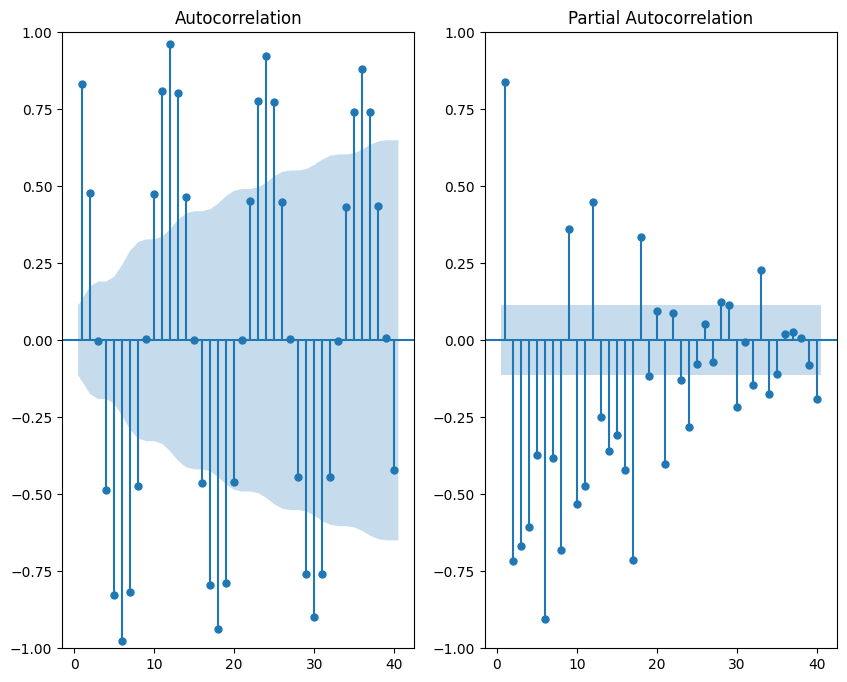

Diferenciada


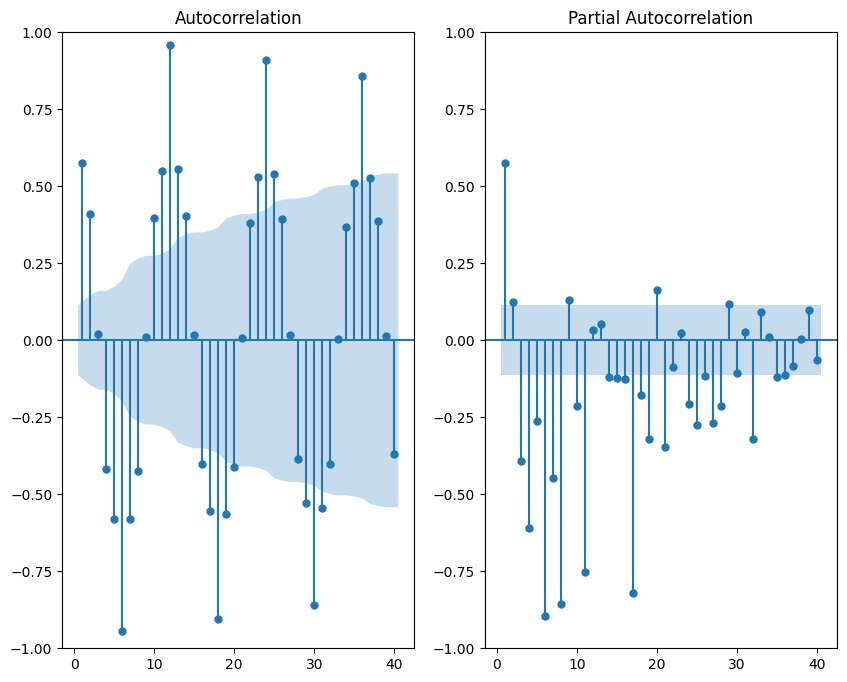

In [22]:
modelo.stationarity()

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary
Results of Dickey-Fuller Test:
Test Statistic                  -2.287739
p-value                          0.175953
#Lags Used                      15.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64
Non-stationary
Sin diferenciar


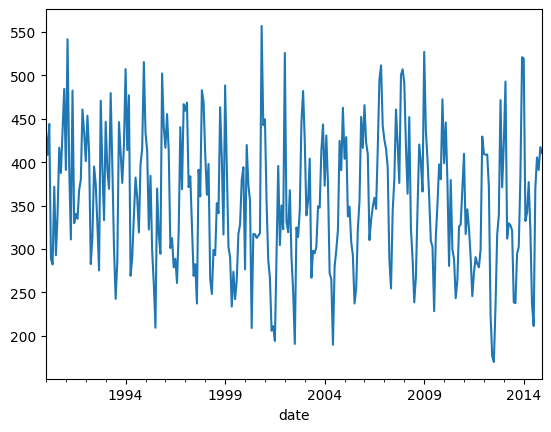

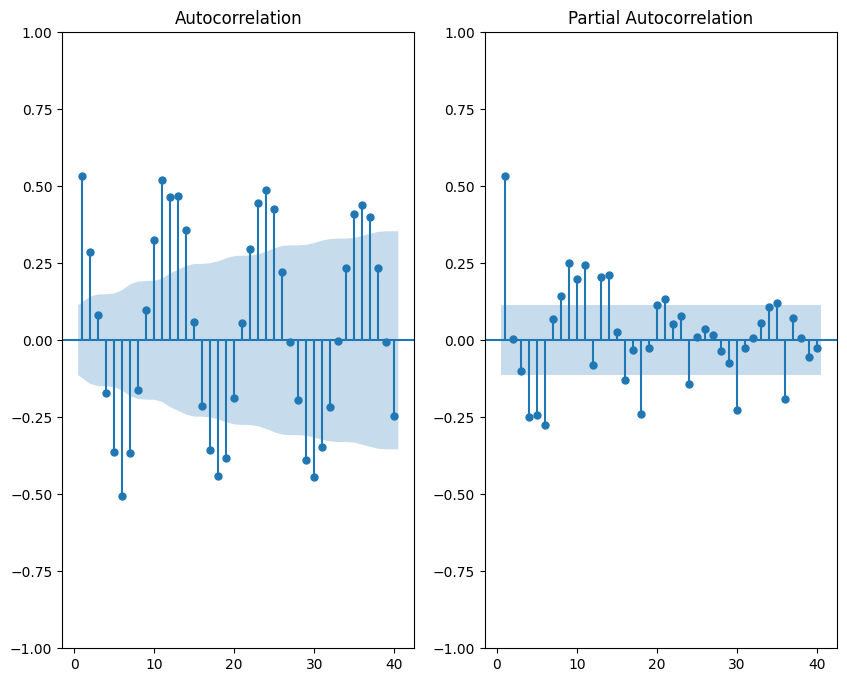

Diferenciada


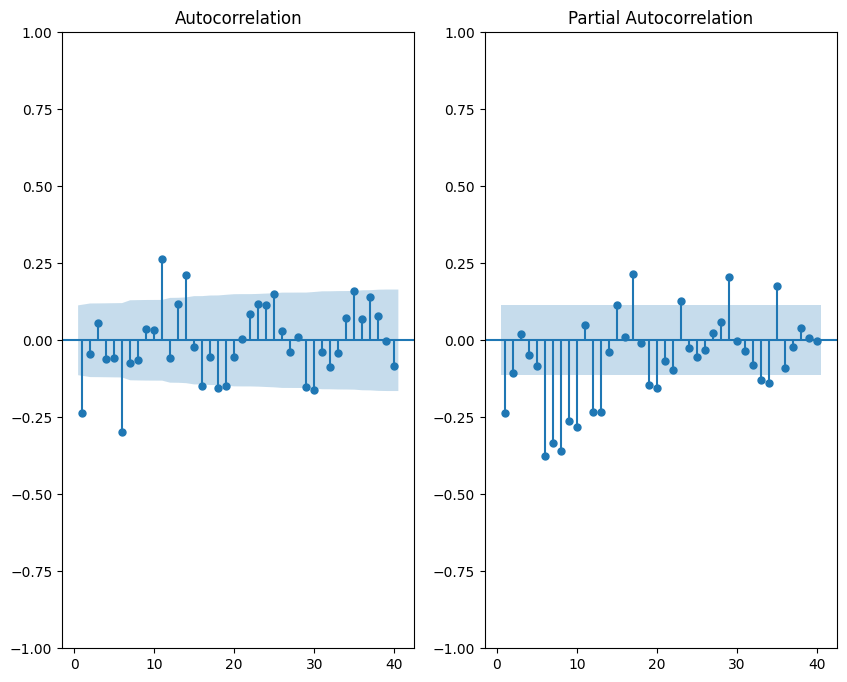

Diferenciada 2 veces


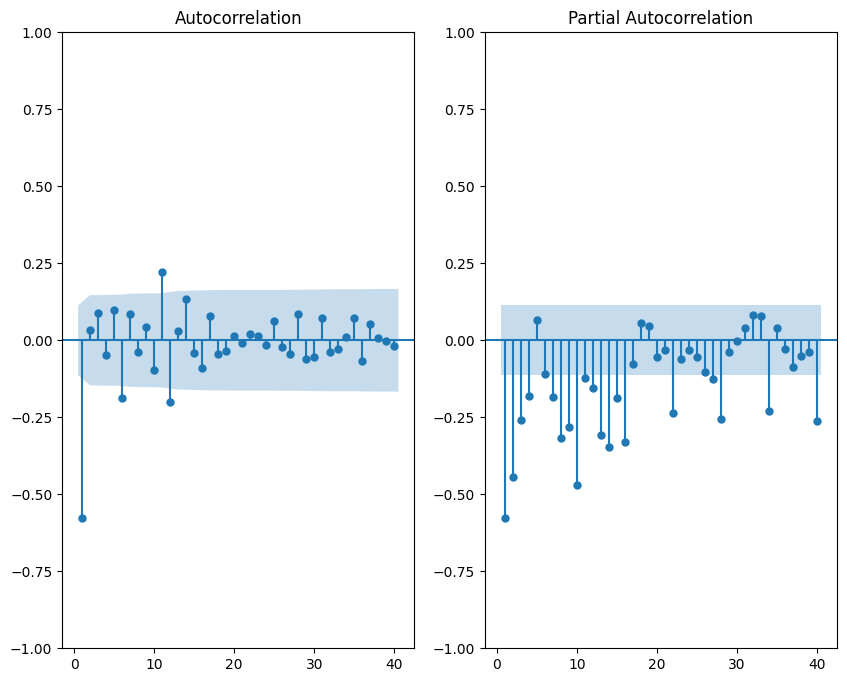

In [23]:
modelo.non_stat_comp(6)

Results of Dickey-Fuller Test:
Test Statistic                  -5.001408
p-value                          0.000022
#Lags Used                      16.000000
Number of Observations Used    282.000000
Critical Value (1%)             -3.453754
Critical Value (5%)             -2.871844
Critical Value (10%)            -2.572261
dtype: float64
Stationary


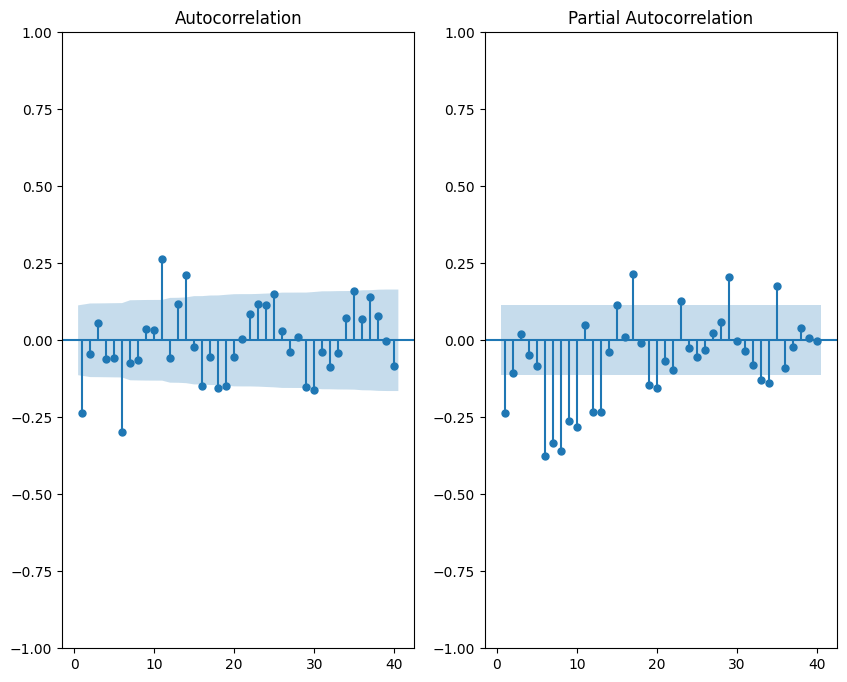

In [24]:
modelo.adf_test(False, modelo.non_seasonal.diff().dropna())
modelo.plot_acf_pacf(1, {'lags': 40}, False, modelo.non_seasonal)

In [25]:
p = [0, 1, 2]
d = [1]
q = [0, 1]
P = [0 ,1, 2]
D = [0]
Q = [0, 1, 2]
modelo.sarimax_param(p, d, q, P, D, Q)

posibleParams = modelo.find_param().sort_values(by=['AIC'], ascending=True);

In [26]:
posibleParams.head()

,params,AIC,BIC,LLF
196,"((2, 1, 1), (1, 0, 1, 6), 'n')",685.099959,707.302621,-336.54998
208,"((2, 1, 1), (2, 0, 1, 6), 'n')",686.686001,712.589106,-336.343001
200,"((2, 1, 1), (1, 0, 2, 6), 'n')",686.723047,712.626152,-336.361523
197,"((2, 1, 1), (1, 0, 1, 6), 'c')",686.900043,712.803148,-336.450022
140,"((1, 1, 1), (2, 0, 2, 6), 'n')",687.199022,713.102127,-336.599511


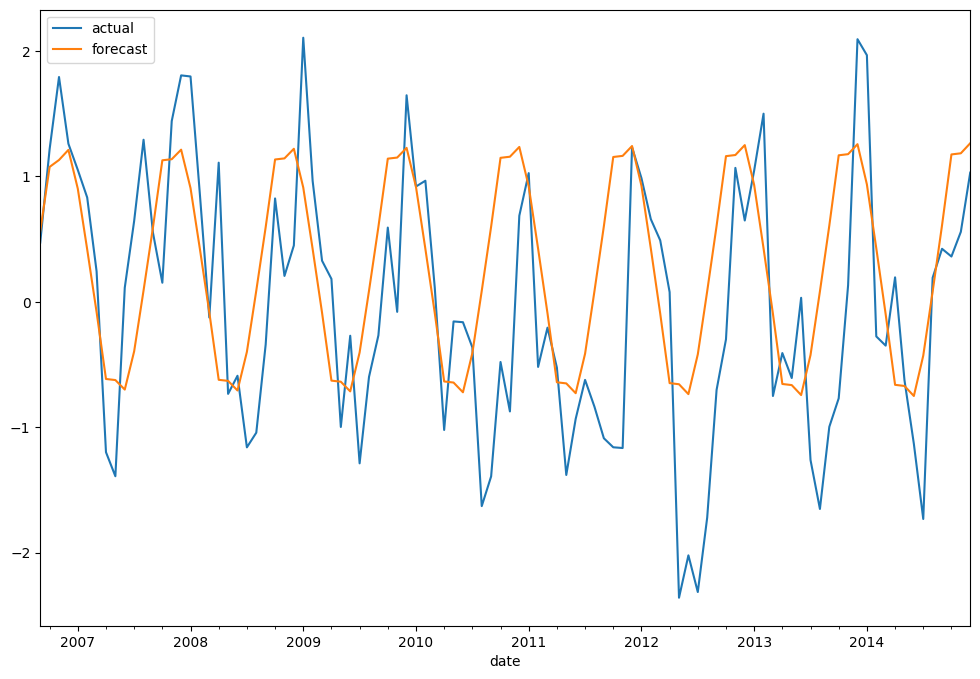

In [27]:
modelo.sarimax_model((2, 1, 1), (1, 0, 1, 6), 'n')
modelo.prediction(100)